# Bayesian Statistics Workshop - Applied Portion
### Hosted by: Eric Zhu | [ezhu.build](https://ezhu.build)
---
The workshop slides will be available on my [Github](https://github.com/GreatArcStudios), which you should be able to find in the same directory as this notebook.

## Aims
- Creating two Bayesian models
- Understanding some pros/cons of Bayesian methods
- Some basic prior setting
- Evaluating Bayesian model performance
- Understanding how to create predictions through the posterior predictive distribution

## Breakdown
- Creating a multiple imputation model (a model that generates a distribution for the "population" and uses that distribution to generate a distribution for our quantity of interest) with random effects.
- The data, while simulated, is provided in the context that a large university is trying to analyse student marks in a large first year class (think Convocation (Con) Hall classes at UofT). In this scenario, the University asked the students to voluntarily participate in a pre-study exam to examine the effects of studying. This pre-study exam is equivalent in skill & difficulty wise to the exam everyone gets. Additionally, the University has access to every student's high school GPA, lecture section, and amount of time studied (perhaps they need to use a VPN to connect to the student portal).
- The student GPAs are on a 4.0 scale, and generally exam scores are within the range of 0-110 due to bonus marks. Ideally, we would use a truncated normal distribution, but for the sake of time we will not cover it.

## Credits

While I  created the materials/scenario for this workshop, I must also credit [Professor Dan Simpson](https://dpsimpson.github.io/) for the inspiration. This workshop was based off of a similar scenario from Homework 2 of the Winter 2021 offering of [STA365](https://www.statistics.utoronto.ca/sites/www.statistics.utoronto.ca/files/STA365H1%20sylabus2021%20%283%29.pdf) at the University of Toronto (UofT). We are not explicitly covering post stratification or truncated distributions in the workshop for the sake of time/accessibility. Additionally, explanations of random effect models generally follow those given by [Professor Liza Bolton](https://www.dataembassy.co.nz/) during the Winter 2021 offering of [STA303/1002](https://www.statistics.utoronto.ca/sites/www.statistics.utoronto.ca/files/STA303-1002_syllabus_W21.pdf).

In [1]:
# packages we need in this workshop
import math
import numpy as np
import pandas as pd
import cmdstanpy
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams["figure.figsize"] = (10,8)
sns.set_style('whitegrid')

# Part 0: Generating the Data
In this workshop, we'll be modelling some generated data. While this means we have a population distribution (the distribution from which we generate from), you'll get to see how Bayesian methods perform in (assumed) frequentist settings, which is pretty cool!

For later: we will be leaving half of the data in one column out in the data I provide since we will be creating a model to predict that data.

### Important: don't look at this section until the end

In [196]:
# init the numpy array to 0s (dataset will be 4-dim)
samples = 5000
data = np.zeros((samples, 5))
rng = np.random.default_rng(seed=123)
# certain lecture sections have on average higher scores
section_dict = {"LEC0101": 5, "LEC0202": 0, "LEC0303": -1.25, "LEC0404": 2}
lecture_sections = rng.choice(["LEC0101", "LEC0202", "LEC0303", "LEC0404"], samples)
entrance_gpa = rng.normal(3.85, 0.05, samples)
prestudy_scores = []
study_times = []
poststudy_scores = []
def generate_data():
    for sample in range(samples):
        lec_section = lecture_sections[sample]
        prestudy_scores.append(rng.normal(57+0.45*entrance_gpa[sample]+section_dict[lec_section], 10, 1))
        study_times.append(rng.normal(10+section_dict[lec_section], 2, 1))
        poststudy_scores.append(rng.normal(58+0.35*entrance_gpa[sample] + 0.5*prestudy_scores[sample] + study_times[sample]*1.2+section_dict[lec_section], 3.25, 1))

generate_data_vectorized = np.vectorize(generate_data)

generate_data_vectorized()
data[:,1] = prestudy_scores
data[:,2] = entrance_gpa
data[:,3] = study_times
data[:,4] = poststudy_scores
data_df = pd.DataFrame(data, columns=["Lecture_Section", "PreStudy_Scores","Entrance_GPA", "Study_Times", "PostStudy_Scores"])
data_df = data_df.round(2)
data_df.iloc[:,0] = lecture_sections
fully_labelled_data = data_df.iloc[:1000]
#print(data_df)
fully_labelled_data.to_csv("full_labelled_workshop_data.csv")
missing_data = data_df.iloc[:1000]
missing_data = missing_data[['Lecture_Section', 'Entrance_GPA', 'Study_Times']]
poststudy_scores_keep = pd.Series(data_df.PostStudy_Scores[:500])
prestudy_scores_keep = pd.Series(data_df.PreStudy_Scores[:500])
missing_data.insert(1, "PreStudy_Scores", prestudy_scores_keep)
missing_data.insert(1, "PostStudy_Scores", poststudy_scores_keep)
missing_data.to_csv("missing_data_workshop_data.csv")

# Part 1: Creating a simple model
We will use this model as the model that creates a population distribution for the missing data, i.e., we will predict the missing data.

To do so, we will use a random effects model, specifically a random effect for $\texttt{lecture_section}$:

\begin{aligned}
\texttt{PreStudy_Scores}_i &= \beta_0 + \beta_1 \cdot \texttt{Entrance_GPA}_i + U_{ij} + \epsilon \\
\beta_0 &\sim N(\mu_{\beta_0}, \tau_{\beta_0}) \\
\beta_1 &\sim N(\mu_{\beta_1}, \tau_{\beta_1}) \\
U &\sim N(0, \tau_U) \\
\tau_{U} &\sim N_+(\mu_{\tau_U}, \tau_{\tau_U}) \\
\sigma &\sim N_+(0, \tau_{\sigma})
\end{aligned}

Note that $U_{ij}$ is the random effect for the $j^{th}$ lecture section that corresponds to the $i^{th}$ individual. Additionally, with a normally distributed error term recall that for models like linear regression, we may represent the model as the likelihood (with $X$ as the $n$ by $p$ design matrix and $w$ as $p$-dim vector of weights): $ y \sim N(Xw, \sigma^2)$.

In $\texttt{lme4}$ style syntax, we may write:

$\texttt{PreStudy_Scores}_i  = \texttt{Entrance_GPA}_i  + (1~|~\texttt{Lecture_Section}_i )$

So we will need 4 priors: $\beta_0, \beta_1, \tau_U, \sigma^2$.

For the first prior, the prior for the intercept, you know that on average students score around a 55% without studying. Although some students are quite good (or perhaps lucky) and score up to 20% higher without studying

As for the prior on $\beta_1$, we know that a student's High School or Secondary Education GPA has a mild effect on their scores before any studying. Perhaps something like a factor of 0.5, although since we know the effect of GPA isn't that large, we don't expect the effect to be sensibly more than twice the average effect (the centre of your prior distribution).

Then for the standard deviation of the random intercept, we know that the intercept can vary in extreme cases by up to 5, i.e., sometimes the lecture section may increase a student's performance by 5 percent! So then, you should expect the lecture section to affect student performance by at least a couple of percent on average, perhaps $\mu_{\tau_U} \approx 2$.

Finally, for $\sigma^2$, the variance of the data, we expect that the distribution is centred around 0. In other words, we can expect our model to be centred around our mean. But the standard deviation of $\sigma^2$ is then rather large, perhaps we could see students who perform up to 20 or 30 percent better holding all other factors constant!

### Remember to use half normal distributions for standard derivation parameters since normal distribution standard deviations are non-negative.

## Prior distributions (solution)

My prior distributions

\begin{aligned}
\beta_0 &\sim N(55, 10) \\
\beta_1 &\sim N(0.3, 0.15) \\
\tau_{U} &\sim N_+(2, 1.25) \\
\sigma &\sim N_+(0, 25)
\end{aligned}


## Code!

In [4]:
# read the data
workshop_data_missing = pd.read_csv("missing_data_workshop_data.csv", index_col=0)
#convert to numerical factor levels
workshop_data_missing['LecSec_Numeric'] = [code+1 for code in pd.Categorical(workshop_data_missing.Lecture_Section).codes]
workshop_data_missing

labelled_data = workshop_data_missing[:500]# get the first two hundred rows and all columns

,Lecture_Section,PostStudy_Scores,PreStudy_Scores,Entrance_GPA,Study_Times,LecSec_Numeric
0,LEC0101,111.29,70.27,3.92,13.08,1
1,LEC0303,100.55,66.24,3.85,7.62,3
2,LEC0303,84.51,52.77,3.81,2.32,3
3,LEC0101,108.98,58.67,3.83,13.59,1
4,LEC0404,101.67,48.77,3.87,15.24,4
...,...,...,...,...,...,...
995,LEC0101,NaN,NaN,3.83,16.88,1
996,LEC0101,NaN,NaN,3.88,15.64,1
997,LEC0404,NaN,NaN,3.85,15.79,4
998,LEC0101,NaN,NaN,3.85,18.62,1


C:\Users\ericz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


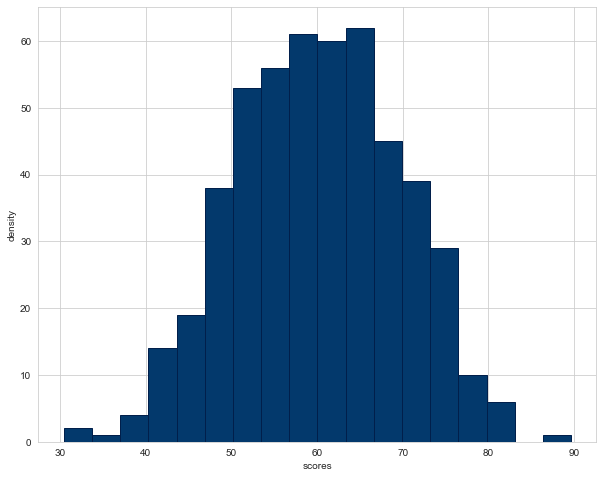

<Figure size 720x576 with 0 Axes>

In [323]:
# Quick EDA, NOT used for determining priors!

# Pre-study scores are roughly normally distributed, as expected
prestudy_plot = plot_distribution(workshop_data_missing.dropna().PreStudy_Scores)

C:\Users\ericz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


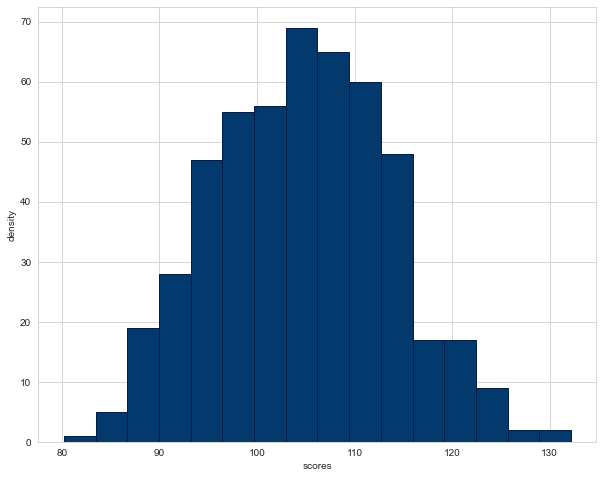

<Figure size 720x576 with 0 Axes>

In [333]:
# Post-study scores
poststudy_plot = plot_distribution(workshop_data_missing.PostStudy_Scores)

LEC0202    139
LEC0101    132
LEC0404    117
LEC0303    112
Name: Lecture_Section, dtype: int64

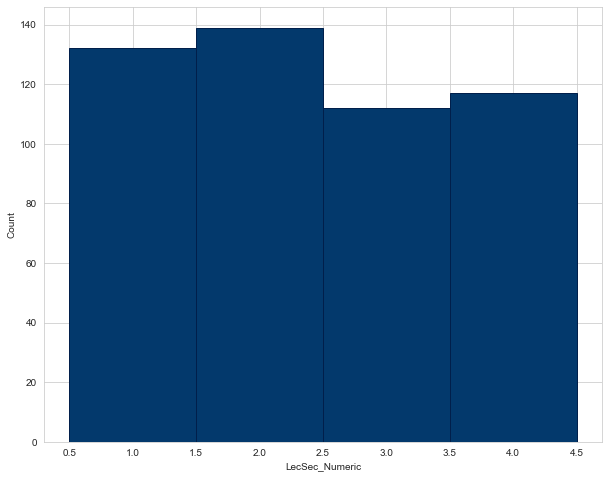

In [332]:
# number of lecture sections
pd.value_counts(labelled_data.Lecture_Section)
lecsec_plot = sns.histplot(labelled_data.LecSec_Numeric, discrete=True, color="#03396c", edgecolor="#011f4b", alpha=1)

In [20]:
# compile the model
prestudy_model = cmdstanpy.CmdStanModel(stan_file="workshop_prestudy.stan")

INFO:cmdstanpy:compiling stan program, exe file: C:/Users/ericz/Desktop/BAYESI~1/Private/BAYESI~1/workshop_prestudy.exe
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: C:/Users/ericz/Desktop/BAYESI~1/Private/BAYESI~1/workshop_prestudy.exe


In [21]:
# create the data lists for Stan
data_list_prestudy = {'N':500,
                      'prestudy_scores': list(labelled_data.PreStudy_Scores),
                      'J_lecsec': len(labelled_data.Lecture_Section.unique()),
                      'lec_sec': list(labelled_data.LecSec_Numeric),
                      'entrance_gpa': list(labelled_data.Entrance_GPA),
                      'mu_sigma' : 0,
                      'tau_sigma': 25,
                      'mu_beta1': 0.5,
                      'tau_beta1': 0.15,
                      'mu_intercept': 55,
                      'tau_intercept': 10,
                      'mu_tau_lecsec': 2,
                      'tau_tau_lecsec': 1.25,
                      'only_prior': 1
                      }
# fit the model
prior_prestudy = prestudy_model.sample(data=data_list_prestudy,
                                       parallel_chains=4,
                                       iter_sampling=1000,
                                       iter_warmup=1000,
                                       refresh=500,
                                       show_progress=True)

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]


Chain 1 - warmup:   0%|          | 0/2000 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|          | 0/2000 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/2000 [00:00<?, ?it/s]


Chain 4 - warmup:  50%|█████     | 1000/2000 [00:00<00:00, 8926.50it/s]


Chain 2 - sample:  50%|█████     | 1000/2000 [00:00<00:00, 8331.44it/s]

Chain 3 - warmup:  50%|█████     | 1000/2000 [00:00<00:00, 8262.55it/s]

Chain 1 - sample:  50%|█████     | 1000/2000 [00:00<00:00, 7934.70it/s]


Chain 2 -   done: 100%|██████████| 2000/2000 [00:01<00:00, 1589.90it/s]


Chain 1 -   done: 100%|██████████| 2000/2000 [00:01<00:00, 1569.06it/s]

Chain 3 - sample: 100%|██████████| 2000/2000 [00:01<00:00, 1559.70it/s]

Chain 4 -   done: 100%|██████████| 2000/2000 [00:01<00:00, 1767.94it/s]


In [22]:
data_list_prestudy['only_prior'] = 0
posterior_prestudy = prestudy_model.sample(data=data_list_prestudy,
                                       parallel_chains=4,
                                       iter_sampling=1000,
                                       iter_warmup=1000,
                                       refresh=500)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


In [24]:
prestudy_az = az.from_cmdstanpy(
    posterior=posterior_prestudy,
    posterior_predictive="y_pred",
    observed_data={'y_pred': list(data_list_prestudy['prestudy_scores'])},
    log_likelihood="log_lik",
    prior = prior_prestudy,
    prior_predictive="y_pred"
)

## Model checking/evaluation

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta_0,beta_1,tau_lecsec,...,y_pred[491],y_pred[492],y_pred[493],y_pred[494],y_pred[495],y_pred[496],y_pred[497],y_pred[498],y_pred[499],y_pred[500]
0,1.577510,0.995086,0.443699,3.0,7.0,0.0,2.709560,55.7224,0.499903,2.017370,...,58.9057,83.2604,34.9224,66.0437,50.8537,51.9637,55.09840,81.7925,71.50760,40.45540
1,0.970548,0.980134,0.443699,3.0,7.0,0.0,1.498260,58.0194,0.287841,3.215020,...,72.8068,67.6540,47.7940,53.6122,48.6485,67.3035,40.29370,48.7942,45.99270,42.37620
2,-1.372890,0.193560,0.443699,3.0,7.0,0.0,7.138940,58.6804,0.293793,1.159880,...,65.0885,77.1029,52.2670,56.1465,57.1172,54.0803,49.44050,58.6477,56.80130,66.08910
3,-2.338770,0.599943,0.443699,3.0,7.0,0.0,5.692980,54.0545,0.594005,3.338820,...,256.7970,91.0069,32.9460,8.7253,-192.3190,113.6770,74.36400,15.3861,153.33000,22.44620
4,-1.610550,0.963508,0.443699,3.0,7.0,0.0,5.277430,33.2371,0.358189,1.732810,...,41.4327,30.7056,26.4290,38.6212,35.4098,30.8344,27.76560,39.4493,33.64670,35.73090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2.043230,0.950019,0.392019,3.0,7.0,0.0,0.460679,55.0779,0.601659,3.577700,...,49.6516,49.6720,65.7550,59.0619,49.9757,85.7299,56.77180,71.4683,61.01450,59.21510
3996,1.021310,0.832377,0.392019,3.0,7.0,0.0,-0.182008,54.1830,0.361384,0.925133,...,29.5788,25.4275,44.1952,-34.0237,36.1777,34.0452,-2.67468,49.5505,-2.76128,5.99675
3997,-2.105110,0.953138,0.392019,3.0,7.0,0.0,3.370230,72.0371,0.612699,0.618500,...,79.8667,68.7533,63.6852,85.0461,77.7152,75.1319,80.08240,73.2520,90.60050,78.22850
3998,-1.258340,0.779503,0.392019,3.0,7.0,0.0,5.986970,70.1026,0.496196,3.061630,...,78.7447,70.1334,78.7842,79.9162,76.8607,79.8077,67.94840,71.0436,74.22690,63.18900


<ipython-input-16-bdaee3d77d4c>:21: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(grid_size, grid_size, i+1)
C:\Users\ericz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


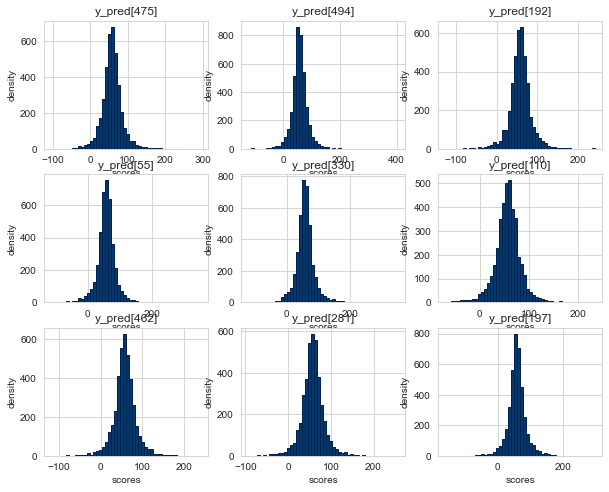

<Figure size 720x576 with 0 Axes>

In [25]:
# prior draws
prior_prestudy_draws = prior_prestudy.draws_pd()
prior_prestudy_draws

# plot posterior pred. KDE estimates
# subset columns we want to plot
prestudy_prior_pred_subset = prior_prestudy_draws.filter(like="y_pred").sample(n=9,axis='columns')
plot_pred_distributions(prestudy_prior_pred_subset)

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta_0,beta_1,tau_lecsec,...,y_pred[491],y_pred[492],y_pred[493],y_pred[494],y_pred[495],y_pred[496],y_pred[497],y_pred[498],y_pred[499],y_pred[500]
0,-1369.90,0.919039,0.196599,4.0,15.0,0.0,1373.58,59.9031,0.254874,1.36274,...,62.7784,51.3380,44.8083,66.5792,55.7153,73.5062,49.5588,51.1319,50.6946,54.0451
1,-1364.99,0.999994,0.196599,4.0,15.0,0.0,1371.42,58.5640,0.561538,1.85387,...,54.7923,64.1984,78.7060,55.4592,60.1993,61.0970,53.6417,60.2116,61.1465,61.3979
2,-1365.60,0.931135,0.196599,4.0,31.0,0.0,1368.72,60.0724,0.476295,1.76844,...,62.4228,58.4202,45.9128,54.2418,68.2869,68.9763,60.4637,62.5127,50.0846,48.2058
3,-1373.84,0.898665,0.196599,4.0,15.0,0.0,1377.98,60.7865,0.187541,1.29317,...,56.4927,57.1168,58.0509,64.9519,54.8629,58.2823,57.1272,56.7896,59.7546,61.4534
4,-1364.21,0.867840,0.196599,4.0,15.0,0.0,1377.74,57.9105,0.794651,2.48307,...,79.7359,63.9301,49.2627,52.3462,72.7303,58.2374,62.4647,63.3626,57.1027,54.0933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1370.28,0.871129,0.228167,4.0,15.0,0.0,1373.31,59.3763,0.220736,1.24234,...,54.8576,55.8461,62.7526,63.2457,68.0079,70.5561,56.6519,63.2230,59.5440,57.8037
3996,-1366.30,0.970072,0.228167,4.0,15.0,0.0,1375.26,55.9148,0.676225,4.19844,...,58.0297,55.4602,56.3668,65.2944,56.3119,62.8509,55.5632,70.9206,70.7988,58.1478
3997,-1363.55,1.000000,0.228167,2.0,3.0,0.0,1367.02,56.0675,0.628071,3.10664,...,69.4861,61.8044,57.5042,62.3631,65.9888,75.4604,60.9738,48.5972,29.5104,52.5170
3998,-1366.65,0.889880,0.228167,3.0,7.0,0.0,1370.54,54.6582,0.790787,3.29334,...,83.0279,52.8972,47.1281,68.5117,51.7104,60.0432,53.5946,47.6568,69.3952,51.5032


C:\Users\ericz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y_pred'>

<ipython-input-16-bdaee3d77d4c>:18: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()
<ipython-input-16-bdaee3d77d4c>:21: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(grid_size, grid_size, i+1)
C:\Users\ericz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Data Point', ylabel='Shape parameter k'>

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,58.045,1.498,55.128,60.702,0.044,0.031,1168.0,2043.0,1.01
beta_1,0.505,0.149,0.220,0.767,0.003,0.002,3412.0,2753.0,1.00
tau_lecsec,2.570,0.807,1.195,4.088,0.021,0.015,1372.0,2458.0,1.00
u_lecsec[0],3.003,1.520,0.259,5.881,0.043,0.030,1260.0,1901.0,1.00
u_lecsec[1],-1.131,1.514,-4.074,1.654,0.041,0.029,1369.0,2281.0,1.00
...,...,...,...,...,...,...,...,...,...
mu[495],62.989,0.804,61.514,64.574,0.012,0.008,4702.0,3160.0,1.00
mu[496],58.880,0.768,57.500,60.307,0.011,0.008,4957.0,3116.0,1.00
mu[497],58.845,0.768,57.458,60.267,0.011,0.008,4950.0,3142.0,1.00
mu[498],60.781,0.822,59.134,62.234,0.012,0.008,4977.0,3421.0,1.00


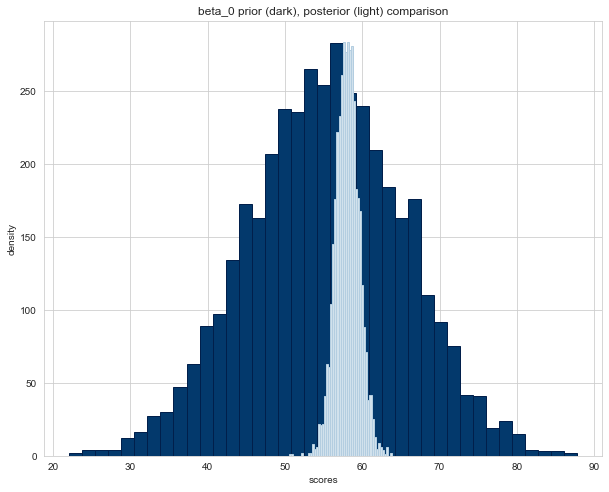

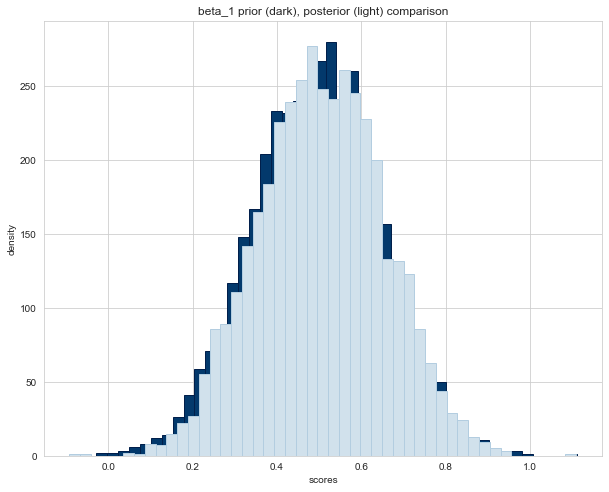

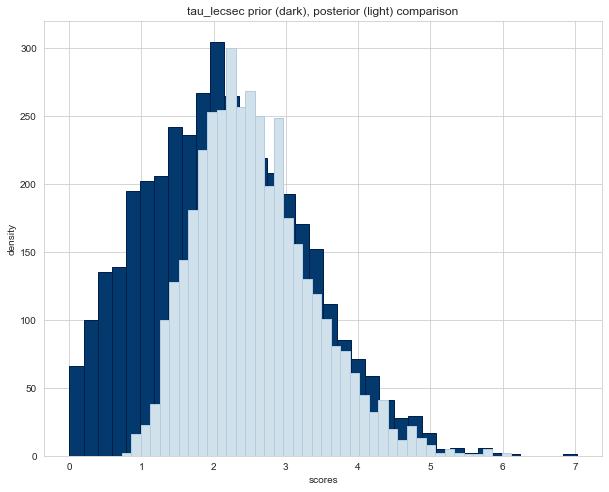

<Figure size 720x576 with 0 Axes>

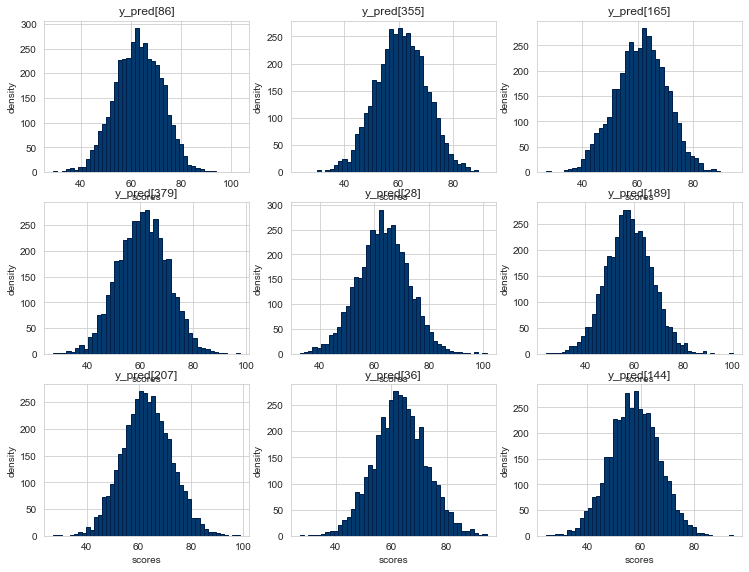

<Figure size 720x576 with 0 Axes>

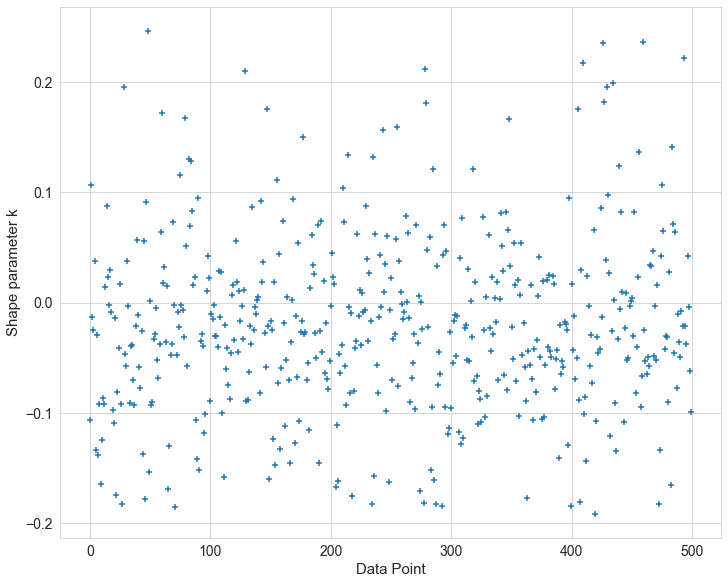

In [26]:
# posterior draws
posterior_prestudy_draws = posterior_prestudy.draws_pd()
posterior_prestudy_draws

# plotting, we will perform posterior checks and predictive checks

# plot the comparison plots
# beta_0 comparison plot
plot_prior_posterior(prior_prestudy_draws.beta_0, posterior_prestudy_draws.beta_0, parameter_name="beta_0")
# beta_1 comparison plot
plot_prior_posterior(prior_prestudy_draws.beta_1, posterior_prestudy_draws.beta_1, parameter_name="beta_1")
# random effect st dev. comparison plot
plot_prior_posterior(prior_prestudy_draws.tau_lecsec, posterior_prestudy_draws.tau_lecsec, parameter_name="tau_lecsec")

# plot the posterior pred. distribution ppc
az.plot_ppc(prestudy_az)

# plot posterior pred. KDE estimates
# subset columns we want to plot
prestudy_posterior_pred_subset = posterior_prestudy_draws.filter(like="y_pred").sample(n=9,axis='columns')
plot_pred_distributions(prestudy_posterior_pred_subset)

# plot the PSIS plot
az.plot_khat(az.loo(prestudy_az, pointwise=True))

# summaries
az.summary(prestudy_az)

# Part 2: Creating the complex model

Now we use the predicted population distribution to construct the distribution of post-study scores. We must use many samples of each lecture section to accurately predict the post-study score. The core idea here is that we must incorporate all of our information about pre-study scores into our distribution for the post-study scores; in other words, we marginalize over the pre-intervention scores.

Then, our model will be:

\begin{aligned}
\texttt{PostStudy_Scores}_i &= \beta_0 + \beta_1 \cdot \texttt{Entrance_GPA}_i + \\
&\beta_2 \cdot \texttt{PreStudy_Scores}_i + \beta_3 \cdot \texttt{Study_Times}_i + U_{ij} + \epsilon \\
\beta_0 &\sim N(\mu_{\beta_0}, \tau_{\beta_0}) \\
\beta_1 &\sim N(\mu_{\beta_1}, \tau_{\beta_1}) \\
\beta_2 &\sim N(\mu_{\beta_2}, \tau_{\beta_2}) \\
\beta_3 &\sim N(\mu_{\beta_3}, \tau_{\beta_3}) \\
U &\sim N(0, \tau_U) \\
\tau_{U} &\sim N_+(\mu_{\tau_U}, \tau_{\tau_U})\\
\sigma &\sim N_+(0, \tau_{\sigma})
\end{aligned}

Note that $U_{ij}$ is the random effect for the $j^{th}$ lecture section that corresponds to the $i^{th}$ individual. Again, with a normally distributed error term recall that for models like linear regression, we may represent the model as the likelihood (with $X$ as the $n$ by $p$ design matrix and $w$ as $p$-dim vector of weights): $ y \sim N(Xw, \sigma^2)$.

In $\texttt{lme4}$ style syntax, we may write:

$\texttt{PostStudy_Scores}_i  = \texttt{PreStudy_Scores}_i + \texttt{Entrance_GPA}_i  + (1~|~\texttt{Lecture_Section}_i)$

So we will need 6 priors: $\beta_0, \beta_1, \beta_2, \beta_3, \tau_U, \sigma^2$.

For the first prior, the prior for the intercept, you know that on average students score around a 55% without studying.

As for the prior on $\beta_1$, we know that a student's High School or Secondary Education GPA has an effect on their scores before any studying. Perhaps something like a factor of 0.3, although since we know the effect of GPA isn't that large, we don't expect the effect to be sensibly more than twice the average effect (the centre of your prior distribution) for almost all students.

For the prestudy scores, we know that a student's pre-study scores can be used a useful predictor of post-study scores, e.g., someone who scores highly on the pre-study exam is likely to score highly again. So then, we expect a mild effect perhaps like a factor of 0.4, and it should have a similar standard deviation to $\beta_1$.

Additionally, we know that studying ($\beta_3$) has an enormous effect on post-study scores. Perhaps in previous years, the University measured the effect to be around 1.2, with generally some small variation in the effect size, i.e., $\pm 0.2$.

Then for the variance of the random intercept, we know that the intercept can vary in extreme cases by up to 5, i.e., sometimes the lecture section may increase a student's performance by 5 percent! So then, you should expect the lecture section to affect student performance by at least a couple of percent on average, perhaps $\mu_{\tau_U} \approx 2$.

Finally, for $\sigma^2$, the variance of the data, we expect that the distribution is centred around 0. In other words, we can expect our model to have no error. But the variance of $\sigma^2$ is then rather large, perhaps we could see students who perform up to 20 percent better despite all other factors constant!

## Prior distributions (solution)

My prior distributions

\begin{aligned}
\beta_0 &\sim N(55, 10) \\
\beta_1 &\sim N(0.3, 0.15) \\
\beta_2 &\sim N(0.5, 0.15) \\
\beta_3 &\sim N(1.2, 0.1) \\
\tau_{U} &\sim N_+(2, 1.25) \\
\sigma &\sim N_+(0, 10)
\end{aligned}

## Code!

In [2]:
# compile the model
poststudy_model = cmdstanpy.CmdStanModel(stan_file="workshop_poststudy.stan")

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/ericz/Desktop/Bayesian stats workshop/Private/Bayesian-Stats-Workshop-Private/workshop_poststudy.exe


In [5]:
# create the data lists for Stan
data_list_poststudy = {'N':500,
                      'prestudy_scores': list(labelled_data.PreStudy_Scores),
                      'J_lecsec': len(labelled_data.Lecture_Section.unique()),
                      'lec_sec': list(labelled_data.LecSec_Numeric),
                      'entrance_gpa': list(labelled_data.Entrance_GPA),
                      'poststudy_scores': list(labelled_data.PostStudy_Scores),
                      'study_times': list(labelled_data.Study_Times),
                      'mu_sigma' : 0,
                      'tau_sigma': 10,
                      'mu_beta1': 0.3,
                      'tau_beta1': 0.15,
                      'mu_beta2': 0.5,
                      'tau_beta2': 0.15,
                      'mu_beta3': 1.2,
                      'tau_beta3': 0.1,
                      'mu_intercept': 55,
                      'tau_intercept': 10,
                      'mu_tau_lecsec': 2,
                      'tau_tau_lecsec': 1.25,
                      'only_prior': 1
                      }
# fit the model
prior_poststudy = poststudy_model.sample(data=data_list_poststudy,
                                       parallel_chains=4,
                                       iter_sampling=1000,
                                       iter_warmup=1000,
                                       refresh=500)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


In [6]:
data_list_poststudy['only_prior'] = 0
posterior_poststudy = poststudy_model.sample(data=data_list_poststudy,
                                       parallel_chains=4,
                                       iter_sampling=1000,
                                       iter_warmup=1000,
                                       refresh=500)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


In [7]:
poststudy_az = az.from_cmdstanpy(
    posterior=posterior_poststudy,
    posterior_predictive='y_pred',
    observed_data={'y_pred': list(data_list_poststudy['poststudy_scores'])},
    log_likelihood="log_lik",
    prior = prior_poststudy,
    prior_predictive= 'y_pred'
)

## Model checking/evaluation

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta_0,beta_1,beta_2,...,y_pred[491],y_pred[492],y_pred[493],y_pred[494],y_pred[495],y_pred[496],y_pred[497],y_pred[498],y_pred[499],y_pred[500]
0,-0.880048,0.855970,0.431889,3.0,7.0,0.0,8.26760,66.4158,0.196231,0.513926,...,128.2960,126.8340,117.6280,93.3519,108.3910,110.1510,98.4816,111.9110,114.4520,116.2600
1,-2.054390,0.862059,0.431889,3.0,7.0,0.0,6.34860,45.5578,0.403404,0.444771,...,91.0473,84.1503,88.1434,71.5038,76.2300,88.9059,79.4748,84.4347,80.9901,86.7829
2,-7.900580,0.833977,0.431889,3.0,7.0,0.0,12.64470,88.5705,0.293418,0.591910,...,146.5850,133.3000,140.8590,115.7750,133.4650,138.8980,147.0670,126.5570,133.5680,125.9100
3,0.127211,1.000000,0.431889,3.0,7.0,0.0,9.72608,58.2630,0.428534,0.336846,...,97.2883,105.0510,86.8245,82.7719,79.2136,106.3860,90.1677,102.8410,108.3510,99.8898
4,-0.711654,0.944813,0.431889,3.0,7.0,0.0,4.34540,63.7390,0.095323,0.727260,...,145.4600,129.0250,118.4790,124.8610,116.5180,116.1980,132.2660,129.3550,131.0290,119.4520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-3.472560,0.957882,0.385067,4.0,15.0,0.0,10.63960,72.7822,0.546170,0.666568,...,133.4000,124.5370,128.6100,111.7140,118.1070,127.2600,120.2880,129.3780,125.0460,132.6570
3996,-5.667890,0.970809,0.385067,3.0,7.0,0.0,9.33231,75.1420,0.389362,0.595684,...,149.6400,148.0390,120.5440,132.9030,108.0180,147.0550,116.7720,109.8430,88.4202,104.1660
3997,-11.291700,0.603287,0.385067,4.0,15.0,0.0,17.89280,81.0857,-0.057991,0.348380,...,120.3820,118.2000,116.0560,105.0630,109.6630,119.2590,112.4520,111.8800,113.1500,117.6280
3998,-0.797032,1.000000,0.385067,3.0,7.0,0.0,13.03100,47.7680,0.269766,0.505815,...,95.6615,98.4680,85.6227,76.0110,88.3692,97.6737,83.3738,94.8482,87.9462,95.0441


<ipython-input-9-bdaee3d77d4c>:21: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(grid_size, grid_size, i+1)
C:\Users\ericz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


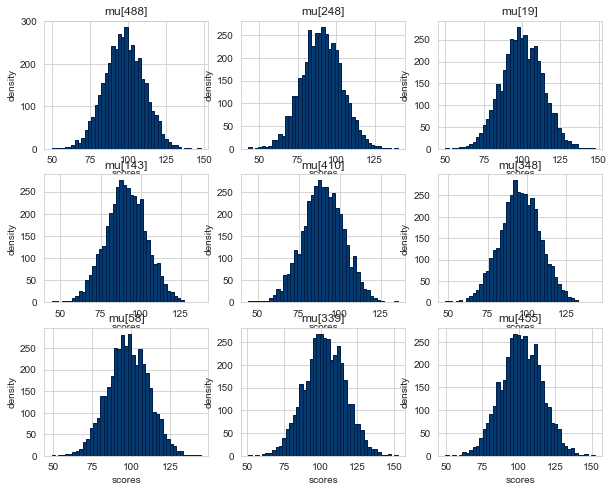

<Figure size 720x576 with 0 Axes>

In [10]:
# prior draws
prior_poststudy_draws = prior_poststudy.draws_pd()
prior_poststudy_draws

# plot posterior pred. KDE estimates
# subset columns we want to plot
poststudy_prior_pred_subset = prior_poststudy_draws.filter(like="mu").sample(n=9,axis='columns')
plot_pred_distributions(poststudy_prior_pred_subset)

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta_0,beta_1,beta_2,...,y_pred[491],y_pred[492],y_pred[493],y_pred[494],y_pred[495],y_pred[496],y_pred[497],y_pred[498],y_pred[499],y_pred[500]
0,-832.961,0.994816,0.053599,6.0,63.0,0.0,841.188,61.4583,0.267613,0.488008,...,121.506,94.8227,105.502,86.1679,93.7238,115.770,92.5965,96.6910,94.9705,103.3770
1,-831.666,0.995404,0.053599,6.0,63.0,0.0,836.070,62.1915,0.313704,0.479764,...,114.513,100.4420,101.995,90.0576,100.1540,110.070,94.9263,99.2251,100.4400,107.5110
2,-830.055,0.947963,0.053599,5.0,31.0,0.0,834.833,62.0907,0.322659,0.479301,...,122.538,99.6254,102.800,94.8210,99.6571,109.716,93.0163,105.2400,106.6220,108.4060
3,-830.336,0.956269,0.053599,6.0,63.0,0.0,832.831,61.0748,0.307892,0.492446,...,108.446,98.3970,98.998,88.5046,93.3680,115.251,99.8776,101.9850,102.9330,106.6170
4,-830.791,0.975309,0.053599,6.0,63.0,0.0,833.041,60.5552,0.217383,0.493956,...,113.403,102.8180,104.519,89.8220,93.7719,107.717,95.9178,101.4580,100.9090,105.1370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-828.988,1.000000,0.059155,6.0,63.0,0.0,831.052,59.9699,0.196473,0.499464,...,115.799,103.0550,103.021,87.5400,91.6390,112.661,91.8090,103.0880,111.2840,102.1860
3996,-833.102,0.941087,0.059155,5.0,47.0,0.0,839.587,58.4241,0.046503,0.507203,...,114.076,102.0910,106.764,86.1838,96.4868,107.456,91.4206,110.3340,106.6930,101.1590
3997,-832.217,0.998896,0.059155,6.0,63.0,0.0,837.153,56.3792,0.451491,0.521285,...,114.713,97.3150,109.608,94.3028,94.2307,114.475,94.8019,106.3170,99.8550,102.9560
3998,-831.940,0.996762,0.059155,6.0,63.0,0.0,838.410,59.9640,0.056230,0.480579,...,116.864,103.2030,102.765,87.2355,94.0608,114.143,103.0990,99.8985,106.8050,104.7020


C:\Users\ericz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y_pred'>

<ipython-input-9-bdaee3d77d4c>:18: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()
<ipython-input-9-bdaee3d77d4c>:21: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(grid_size, grid_size, i+1)
C:\Users\ericz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Data Point', ylabel='Shape parameter k'>

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,60.119,1.849,56.465,63.428,0.051,0.036,1305.0,1823.0,1.0
beta_1,0.297,0.150,0.025,0.573,0.002,0.002,4363.0,2880.0,1.0
beta_2,0.496,0.015,0.468,0.525,0.000,0.000,3251.0,2751.0,1.0
beta_3,1.176,0.057,1.064,1.276,0.001,0.001,3606.0,2803.0,1.0
tau_lecsec,2.790,0.781,1.522,4.351,0.018,0.013,1676.0,2079.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[495],110.930,0.326,110.285,111.507,0.005,0.004,4013.0,3333.0,1.0
mu[496],95.983,0.303,95.444,96.567,0.005,0.003,4144.0,3839.0,1.0
mu[497],102.570,0.318,101.962,103.158,0.005,0.004,3777.0,3628.0,1.0
mu[498],104.209,0.301,103.665,104.803,0.005,0.003,4010.0,2629.0,1.0


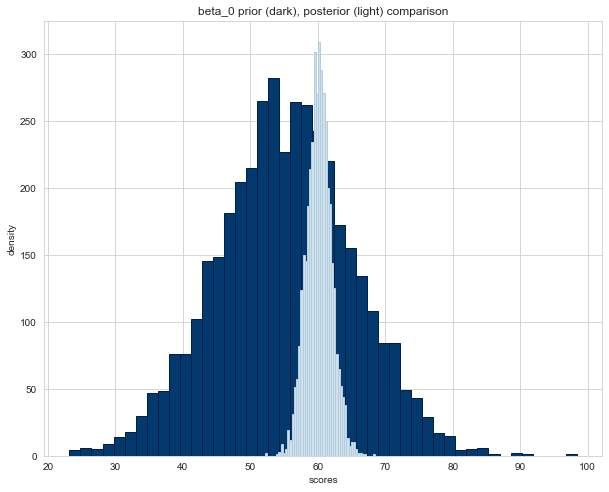

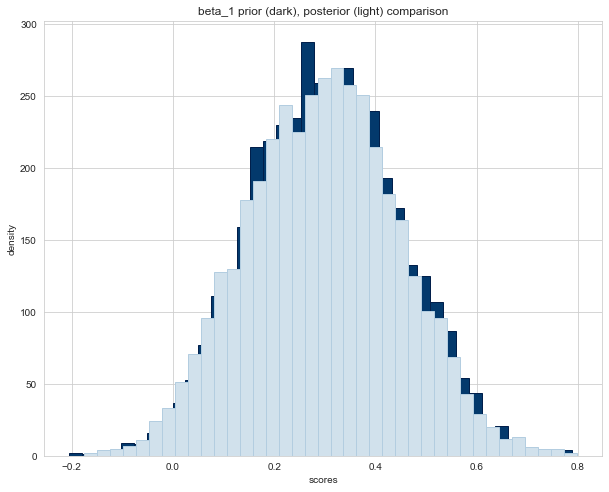

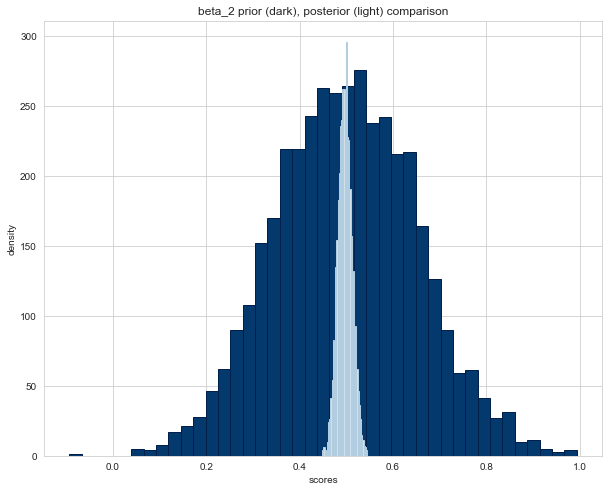

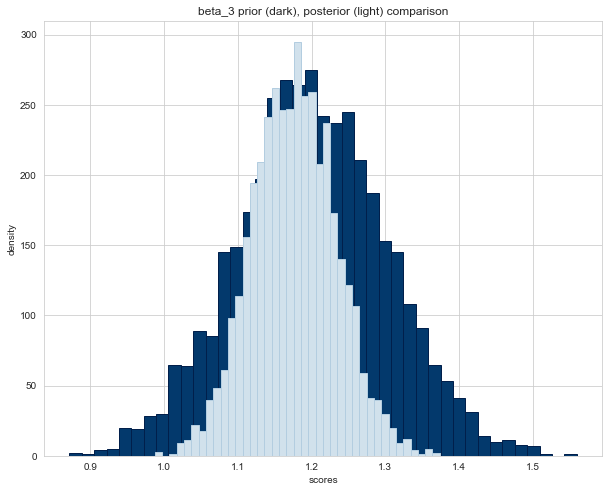

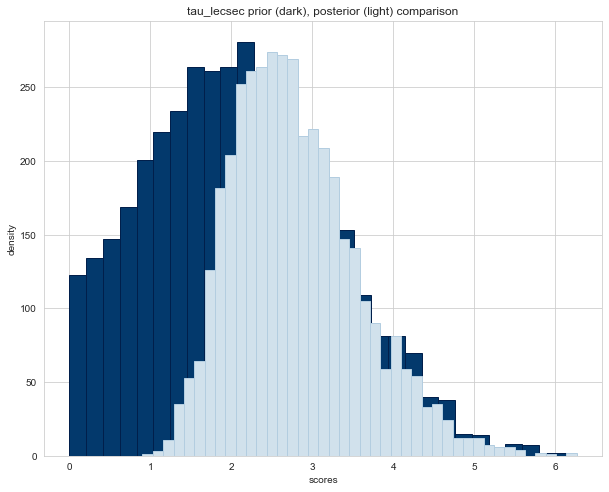

<Figure size 720x576 with 0 Axes>

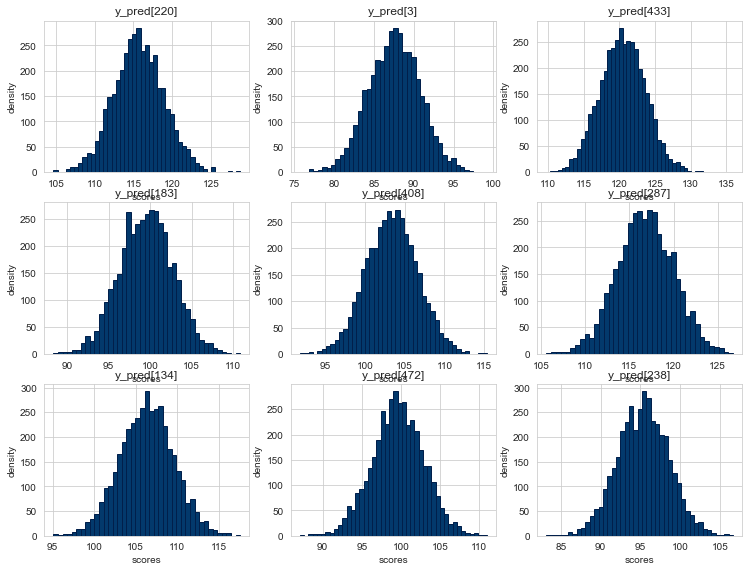

<Figure size 720x576 with 0 Axes>

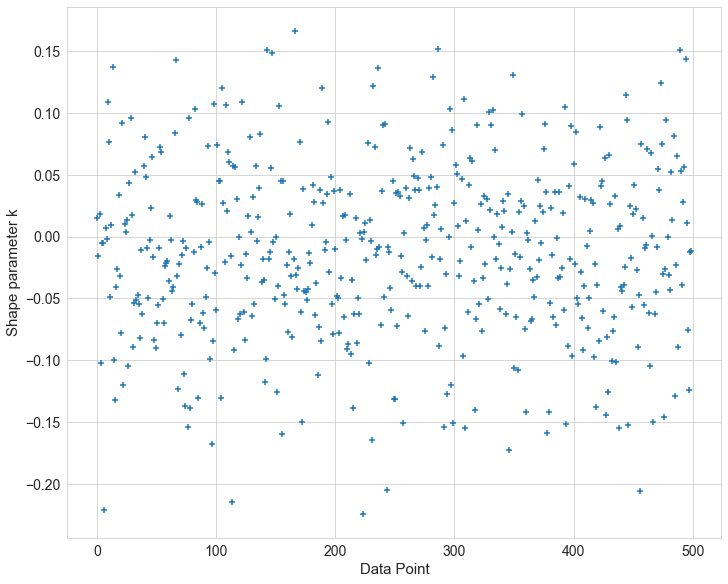

In [11]:
# posterior draws
posterior_poststudy_draws = posterior_poststudy.draws_pd()
posterior_poststudy_draws

# plotting, we will perform posterior checks and predictive checks

# plot the comparison plots
# beta_0 comparison plot
plot_prior_posterior(prior_poststudy_draws.beta_0, posterior_poststudy_draws.beta_0, parameter_name="beta_0")
# beta_1 comparison plot
plot_prior_posterior(prior_poststudy_draws.beta_1, posterior_poststudy_draws.beta_1, parameter_name="beta_1")
# beta_1 comparison plot
plot_prior_posterior(prior_poststudy_draws.beta_2, posterior_poststudy_draws.beta_2, parameter_name="beta_2")
plot_prior_posterior(prior_poststudy_draws.beta_3, posterior_poststudy_draws.beta_3, parameter_name="beta_3")
# random effect st dev. comparison plot
plot_prior_posterior(prior_poststudy_draws.tau_lecsec, posterior_poststudy_draws.tau_lecsec, parameter_name="tau_lecsec")

# plot the posterior pred. distribution ppc
az.plot_ppc(poststudy_az)

# plot posterior pred. KDE estimates
# subset columns we want to plot
poststudy_posterior_pred_subset = posterior_poststudy_draws.filter(like="y_pred").sample(n=9,axis='columns')
plot_pred_distributions(poststudy_posterior_pred_subset)

# plot the PSIS plot
az.plot_khat(az.loo(poststudy_az, pointwise=True))

# summaries
az.summary(poststudy_az)

# Evaluate how studying went
We will first need to predict the population distribution for pre-study scores and then use those predictions to predict the distribution for post-study scores. By doing so we are able to consider all of the entrance GPAs, study times, lecture sections, and pre-study scores, i.e., we are able to marginalize out everything and obtain the distribution for just post-study scores.

## Create the predictions
We create these outside of Stan since it is easier to do so. It would be possible to do so, but it would be less clean.

In [23]:
# first subset the draws dataframes and transpose them so that we have each row corresponding to an individual
posterior_prestudy_ppd = posterior_prestudy_draws.filter(like='y_pred').T
posterior_poststudy_ppd = posterior_poststudy_draws.filter(like='y_pred').T

NameError: name 'posterior_prestudy_draws' is not defined

In [17]:
def create_pred_distribution(data_df, population_df, impute_var ='prestudy_scores', predictor_list = [], impute_df = None,  n_samples=20):
    """
    We want to predict the population distribution by drawing n_samples from the PPD.
    Choose 20 samples by default because of time constraints and works reasonably well
    :param data_df: the posterior pred. distribution df
    :param population_df: the population df, i.e., the dataframe constructed from given data
    :param n_samples: the number of samples to draw from the PPD
    :param predictor_list: the list of predictors we use to create predictions
    :param impute_var: the variable we will impute
    :param impute_df: the datafram containing the data we impute from
    :return: a dataframe of the predicted population distribution
    """
    popn_distribution = pd.DataFrame()
    for index, row in population_df.iterrows():
        lecture_section = row.LecSec_Numeric
        matching_sections = data_df.filter(like=f'u_lecsec[{lecture_section}]')
        prediction = pd.Series(np.zeros(shape=(n_samples)))
        for predictor, var_name in predictor_list:
            # get the vector of posterior weights for each coeff
            if 'u_lecsec' in predictor:
                posterior_weights = matching_sections.sample(n_samples).iloc[:, 0]
            elif predictor == impute_var:
                ppd_prediction_draws = impute_df.filter(like='y_pred').T
                posterior_weights = data_df[predictor].sample(n_samples) * ppd_prediction_draws.sample(n_samples)
            else:
                posterior_weights = data_df[predictor].sample(n_samples)
                if predictor != 'beta_0':
                    posterior_weights = posterior_weights * population_df[var_name].iloc[index]
            # generate the prediction
            prediction = prediction + posterior_weights.reset_index(drop=True)
        popn_distribution = popn_distribution.append(prediction, ignore_index=True)
    return popn_distribution

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
C:\Users\ericz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


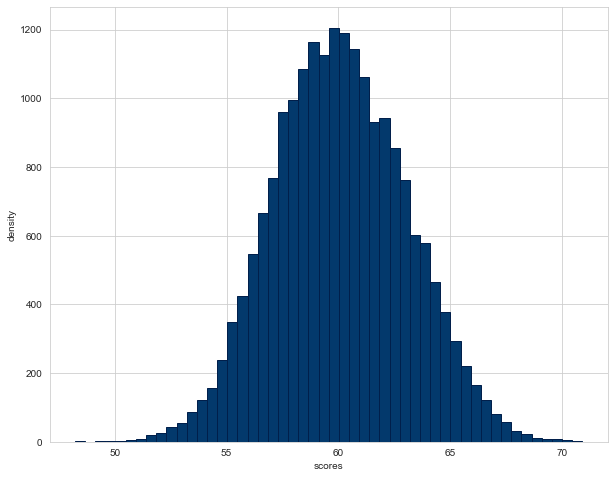

<Figure size 720x576 with 0 Axes>

In [27]:
# compute the pre-study population distribution
prestudy_popn = create_pred_distribution(posterior_prestudy_draws,
                                         workshop_data_missing,
                                         predictor_list=[('beta_0',''), ('beta_1','Entrance_GPA'), ('u_lecsec','')])

plot_distribution(prestudy_popn)

C:\Users\ericz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


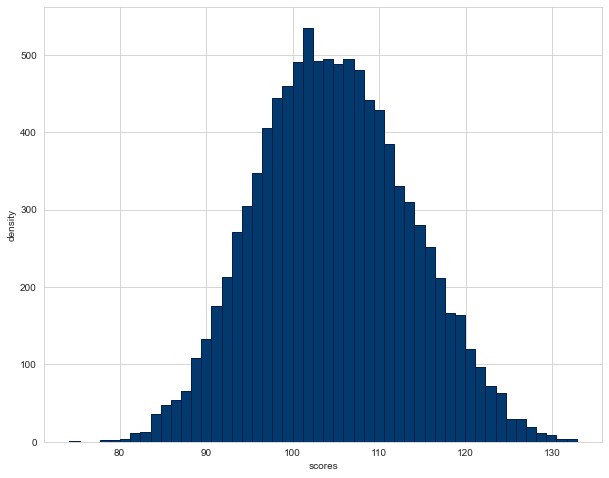

<Figure size 720x576 with 0 Axes>

In [29]:
# compute the post-study population distribution
poststudy_popn = create_pred_distribution(posterior_poststudy_draws,
                                         workshop_data_missing,
                                         predictor_list=[('beta_0',''),
                                                         ('beta_1','Entrance_GPA'),
                                                         ('beta_2', 'PreStudy_Scores'),
                                                         ('beta_3', 'Study_Times'),
                                                         ('u_lecsec','')])

plot_distribution(poststudy_popn)


C:\Users\ericz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


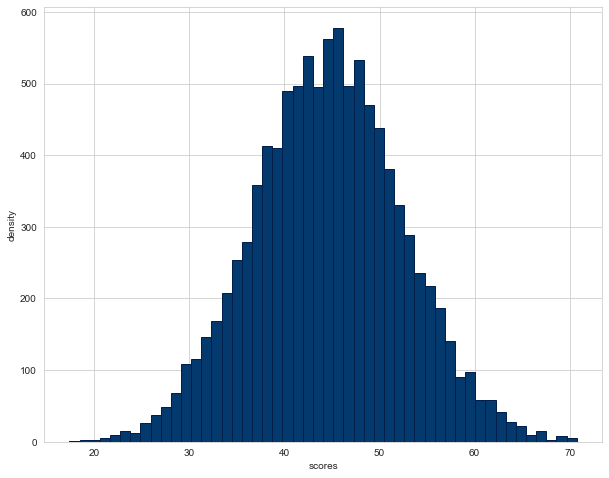

<Figure size 720x576 with 0 Axes>

In [336]:
# compute the difference
study_diff = poststudy_popn - prestudy_popn
plot_distribution(study_diff)

## Now for the comparison to the simulated data!

C:\Users\ericz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


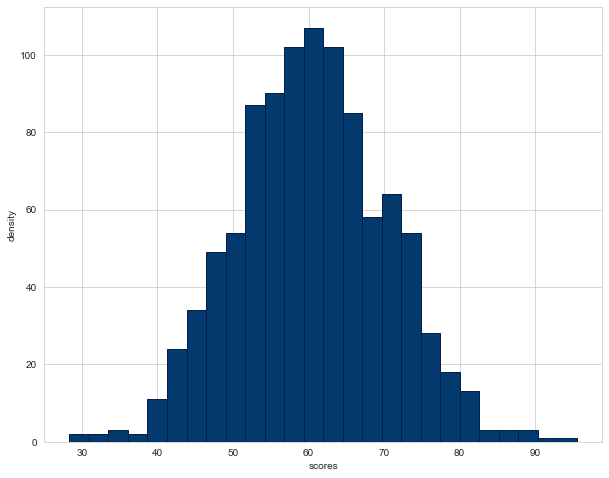

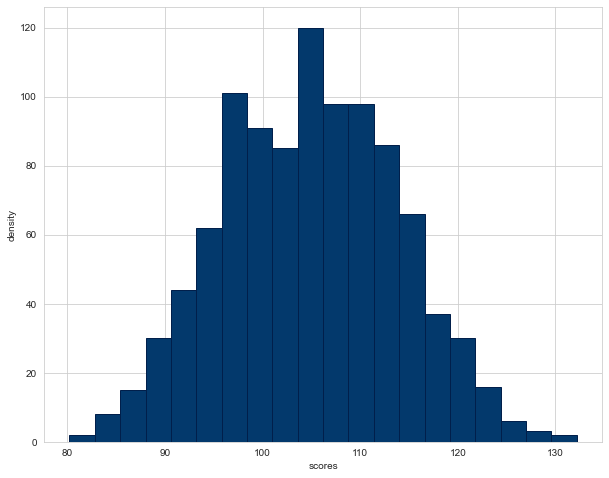

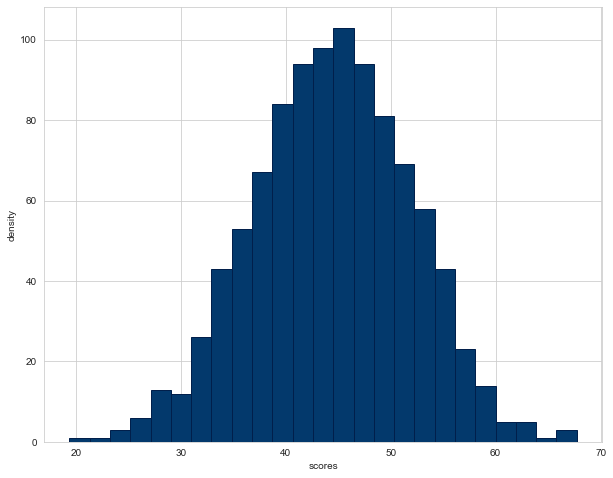

<Figure size 720x576 with 0 Axes>

In [30]:
full_data = pd.read_csv("full_labelled_workshop_data.csv", index_col=0)
plot_distribution(full_data.PreStudy_Scores)
plot_distribution(full_data.PostStudy_Scores)
plot_distribution(full_data.PostStudy_Scores - full_data.PreStudy_Scores)

# Util functions

In [16]:
def plot_prior_posterior(prior_data, posterior_data, parameter_name=""):
    sns.distplot(prior_data, color="#03396c", hist_kws=dict(edgecolor="#011f4b", alpha=1), kde=False) #prior
    sns.distplot(posterior_data, color="#d1e1ec", hist_kws=dict(edgecolor="#b3cde0", alpha=1), kde=False)# posterior
    plt.title(f'{parameter_name} prior (dark), posterior (light) comparison')
    plt.xlabel('scores')
    plt.ylabel('density')
    plt.figure()

def plot_distribution(data, parameter_name=""):
    sns.distplot(data, color="#03396c", hist_kws=dict(edgecolor="#011f4b", alpha=1), kde=False)# posterior
    plt.title(f'{parameter_name}')
    plt.xlabel('scores')
    plt.ylabel('density')
    plt.figure()

def plot_pred_distributions(pred_distn_df):
    grid_size = math.sqrt(len(pred_distn_df.columns))
    plt.tight_layout()
    for i in range(len(pred_distn_df.columns)):
        data = pred_distn_df.iloc[:, i] # column as a series
        plt.subplot(grid_size, grid_size, i+1)
        sns.distplot(data, color="#03396c", hist_kws=dict(edgecolor="#011f4b", alpha=1), kde=False)# posterior
        plt.title(f'{data.name}')
        plt.xlabel('scores')
        plt.ylabel('density')
    plt.figure()